<a href="https://colab.research.google.com/github/JuliaOttolino/Ottolino_Projects/blob/main/OTTOLINO_AUSTIN_COLLISION_UNIT_2_BUILD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**AUSTIN COLLISIONS**
---
###We will attempt to predict the urgent crashes within the Austin City Limits
---

#Install Needed Packages

In [2]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

#Import Necessary Modules

In [3]:
from category_encoders import OrdinalEncoder, OneHotEncoder
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from pandas_profiling import ProfileReport
from xgboost import XGBClassifier
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



%matplotlib inline

!pip install dash
from datetime import date
import dash
from dash.dependencies import Input, Output
import dash_html_components as html
import dash_core_components as dcc

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 7.3 MB 5.0 MB/s 
     |████████████████████████████████| 23.9 MB 2.0 MB/s 
     |████████████████████████████████| 357 kB 15.7 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=0a57c3095ce091f4f72563642a1646e82c5a052d717ca635bb4752c8a9b9371d
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=6992d6addcfaeb51c9d8b7c2015bbbe1b07a1b15160e3a6ed7ae9ed83e9e50e1
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349ebfda451de
  Created wheel for dash-table: filename=dash_table-5.0.0-py3-none-any.whl size=3911 sha256=aba2996a614bed87c038f05faf8f583bfd3997f982fb2c9d72080a0786254837
  Stored in directory: /root/.cache/pip/wheels/85/5d/4e/7c276b57992951dbe770bf5caad6448d0539c510663aef

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


#Load Data

In [4]:
url = 'https://raw.githubusercontent.com/JuliaOttolino/Hola-Martians/main/Real-Time_Traffic_Incident_Reports.csv'

u = 'https://raw.githubusercontent.com/JuliaOttolino/Hola-Martians/main/history_data.csv'

d = pd.read_csv(u)#,index_col='Date time')

In [5]:

d

,Name,Date time,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
0,"Austin, TX, United States",10/13/2020,89.3,57.5,72.3,NaN,86.2,0.00,0.0,0.0,4.2,124.63,NaN,9.9,9.1,44.13,Clear
1,"Austin, TX, United States",10/14/2020,92.3,60.7,75.8,NaN,94.3,0.00,0.0,0.0,9.7,132.25,22.8,9.9,5.4,57.49,Clear
2,"Austin, TX, United States",10/15/2020,88.4,67.1,77.7,NaN,91.1,0.00,0.0,0.0,14.3,206.67,30.4,9.4,75.7,66.02,Overcast
3,"Austin, TX, United States",10/16/2020,76.9,59.9,68.1,NaN,NaN,0.00,0.0,0.0,18.3,40.75,37.9,9.9,46.8,38.73,Partially cloudy
4,"Austin, TX, United States",10/17/2020,78.9,55.4,67.6,NaN,NaN,0.01,0.0,0.0,11.4,135.79,25.3,8.8,87.9,69.12,"Rain, Overcast"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,"Austin, TX, United States",10/11/2021,82.4,61.9,71.7,NaN,81.3,0.72,0.0,0.0,13.2,139.58,35.7,9.4,38.7,62.20,"Rain, Partially cloudy"
364,"Austin, TX, United States",10/12/2021,87.2,69.9,77.2,NaN,94.2,0.05,0.0,0.0,13.1,143.08,26.5,8.1,79.5,77.97,"Rain, Overcast"
365,"Austin, TX, United States",10/13/2021,87.5,67.8,80.7,NaN,92.9,1.04,0.0,0.0,10.9,165.00,24.7,9.3,90.7,74.33,"Rain, Overcast"
366,"Austin, TX, United States",10/14/2021,78.3,67.6,73.0,NaN,NaN,1.15,0.0,0.0,8.0,95.58,17.2,8.6,78.9,87.76,"Rain, Overcast"


#Wrangle and Merge both Dataframes

In [6]:
drop_col = ['Status Date', 'Location', 'Status', 'Traffic Report ID','Date time','Date time','Address', 'Wind Chill','Heat Index','Wind Gust','Maximum Temperature',	'Minimum Temperature', 'Conditions', 'Snow', 'Wind Direction', 'Cloud Cover',	'Relative Humidity']#, 'Maximum Temperature','Cloud Cover', 'Relative Humidity']

In [7]:
def wrangle(df): 
  df = pd.read_csv(url,converters={'Issue Reported': lambda x: int(x == 'Crash Urgent')}) #make target binary
  
  #Get Date columns to match for later merge
  df['Published Date'] = df['Published Date'].astype(str)
  df['Published Date'] = df['Published Date'].str[:10]

  #Drop outliers due to imputation errors
  df = df[(df['Latitude'] >= np.percentile(df['Latitude'], 0.18)) & 
          (df['Latitude'] < np.percentile(df['Latitude'], 99.95)) &
          (df['Longitude'] >= np.percentile(df['Longitude'], 0.15))]

  df = df.rename(columns={'Issue Reported':'Urgent Accidents'})

  #Merge Data
  df = df.rename(columns={'Published Date':'Date time'})
  df = pd.merge(df, d, on=['Date time'], how='outer')

  #Create index
  df.set_index(df['Date time'],inplace=True)

  #Drop columns
  constant_columns = [col for col in df.columns if df[col].nunique() == 1]
  df = df.drop(columns=constant_columns)

  df.drop(columns= drop_col,inplace=True)

  
  


   


  return df

df = wrangle(url)

df

,Urgent Accidents,Latitude,Longitude,Temperature,Precipitation,Snow Depth,Wind Speed,Visibility
Date time,,,,,,,,
10/13/2020,0,30.446400,-97.734289,72.3,0.0,0.0,4.2,9.9
10/13/2020,0,30.303977,-97.757485,72.3,0.0,0.0,4.2,9.9
10/13/2020,0,30.267144,-97.757313,72.3,0.0,0.0,4.2,9.9
10/13/2020,0,30.370967,-97.802974,72.3,0.0,0.0,4.2,9.9
10/13/2020,0,30.166214,-97.801260,72.3,0.0,0.0,4.2,9.9
...,...,...,...,...,...,...,...,...
10/15/2021,0,30.182803,-97.541584,75.6,0.0,0.0,14.1,8.3
10/15/2021,0,30.286523,-97.704868,75.6,0.0,0.0,14.1,8.3
10/15/2021,0,30.167162,-97.791132,75.6,0.0,0.0,14.1,8.3


In [8]:
df['Longitude'].max()

-97.375361

In [9]:
df['Latitude'].max()

30.596348

In [10]:
df['Latitude'].min()

30.005806

In [11]:
df.dtypes

Urgent Accidents      int64
Latitude            float64
Longitude           float64
Temperature         float64
Precipitation       float64
Snow Depth          float64
Wind Speed          float64
Visibility          float64
dtype: object

In [12]:
12012/(38041+12012)

0.2399856152478373

#Balance Target Column

In [13]:
df['Urgent Accidents'].value_counts()

0    37856
1    12006
Name: Urgent Accidents, dtype: int64

In [14]:
df_minority = df[df['Urgent Accidents']==1]
df_majority = df[df['Urgent Accidents']==0]

In [15]:
maj_class = resample(df_majority, 
                                 replace=True,     
                                 n_samples=12012,    
                                 random_state=100)

In [16]:
df=pd.concat([df_minority,maj_class])

In [17]:
df['Urgent Accidents']

Date time
10/13/2020    1
10/13/2020    1
10/13/2020    1
10/13/2020    1
10/14/2020    1
             ..
10/13/2021    0
04/16/2021    0
11/21/2020    0
11/06/2020    0
03/11/2021    0
Name: Urgent Accidents, Length: 24018, dtype: int64

#Create the feature matrix and target array

In [18]:
target = 'Urgent Accidents'

y = df[target]
X = df.drop(columns=target)

#Create a train/test split

In [19]:
#mask = df.index < '04/2021'

#X_train, y_train = X[mask], y[mask]
#X_val, y_val = X[~mask], y[~mask]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

assert len(X_train) + len(X_val) == len(X)

#Establish the Baseline Accuracy

In [20]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.5011103400416378


#Build Models

- `RandomForestClassifier`
- `XGBClassifier`

In [21]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(max_depth=15,max_features=0.09997491581800289,n_estimators = 137, random_state=42) # n_estimators default it 100 so changing 25 for time effectiveness.
)

# model_rf.fit(X_train,y_train) #if you want to compare cv with train-val process

In [77]:
model_xgb = make_pipeline(
    OrdinalEncoder(cols=[], drop_invariant=False,handle_missing='value',
                   handle_unknown='value',mapping=[], return_df=True,
                   verbose=0),
    OneHotEncoder(),
    SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                  strategy='mean',verbose=0),
    GradientBoostingClassifier(n_estimators=5, max_depth = 5, random_state=0,
                               max_features = 0.9507143064099162)
)

model_xgb.fit(X_train, y_train);

#Tune Model

In [72]:
param_rf = { 
    'n_estimators': randint(5,50,100), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

model_rfrs = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_rf, 
    n_iter=5, 
    cv=5, 
    verbose=10, 
    n_jobs=-1, 
    random_state=42
)

model_rfrs.fit(X, y);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.0min finished


In [26]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

gbx_gs = RandomizedSearchCV(gbc,parameters,cv=5)
gbx_gs.fit(X,y.values.ravel())

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [75]:
print('RandomForestClassifier best_params:',model_rfrs.best_params_)
print('RandomForestClassifier best_score:',model_rfrs.best_score_)
print()
print('GradientBoostingClassifier best_params:',gbx_gs.best_params_)
print('GradientBoostingClassifier best_score:',gbx_gs.best_score_)

RandomForestClassifier best_params: {'max_depth': None, 'max_features': 0.596850157946487, 'n_estimators': 123}
RandomForestClassifier best_score: 0.3699303602747589

GradientBoostingClassifier best_params: {'n_estimators': 5, 'max_depth': 1, 'learning_rate': 0.1}
GradientBoostingClassifier best_score: 0.5983431462746275


#Check Metrics

#####**Accuracy Score**

In [78]:
print('Training Accuracy:', model_xgb.score(X_train, y_train))
print('Validation Accuracy:', model_xgb.score(X_val, y_val))

Training Accuracy: 0.6572519083969466
Validation Accuracy: 0.6533097418817652


#####**Confusion Matrix**

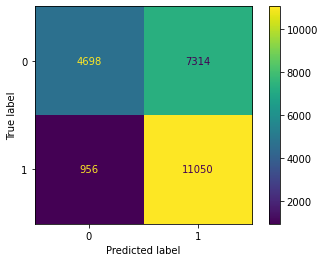

In [29]:
plot_confusion_matrix(
    model_xgb,
    X,
    y,
    values_format = '.0f',
    #display_labels = ['no repair needed', 'needs repair']
    
)

In [30]:
y.value_counts()

0    12012
1    12006
Name: Urgent Accidents, dtype: int64

#####**Classification Report**

In [31]:
print(classification_report(y_val,
                      model_xgb.predict(X_val),
                      target_names =['no repair needed','needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.82      0.39      0.53      4791
    needs repair       0.60      0.92      0.73      4817

        accuracy                           0.65      9608
       macro avg       0.71      0.65      0.63      9608
    weighted avg       0.71      0.65      0.63      9608



#Download chosen model

In [32]:
import joblib
from joblib import dump
dump(model_xgb,'pipeline.joblib',compress=True)

['pipeline.joblib']

In [33]:
row = X_val.iloc[[-100]] # Dataframe with a single row (double brackets keeps it a dataframe)
row

,Latitude,Longitude,Temperature,Precipitation,Snow Depth,Wind Speed,Visibility
Date time,,,,,,,
02/09/2021,30.46065,-97.840575,56.6,0.0,0.0,13.0,7.6


In [34]:
y_val.iloc[[777]]

Date time
04/21/2021    1
Name: Urgent Accidents, dtype: int64

In [35]:
y_val

Date time
12/16/2020    1
04/22/2021    1
08/03/2021    0
05/18/2021    0
02/03/2021    0
             ..
07/02/2021    1
05/15/2021    0
12/06/2020    1
01/12/2021    1
07/19/2021    1
Name: Urgent Accidents, Length: 9608, dtype: int64

In [36]:
model_xgb.predict(row)

array([0])

#Fit Gradient Boosting model

In [37]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.176450863389082


#Explaining Gradient Boosting
To see the relationship between individual features and the target, we can use partial dependence plots.

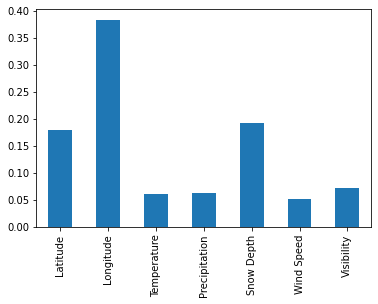

In [38]:
pd.Series(gb.named_steps['xgbregressor'].feature_importances_, index=X_val.columns).plot(kind='bar');

In [39]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Snow Depth'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

In [54]:
X_train['Snow Depth'].shape

(14410,)

In [55]:
(14410-13895)/14410

0.03573907009021513

In [51]:
X_train['Snow Depth'].value_counts()

0.00    13895
3.62      109
1.28       57
5.30       51
0.80       48
2.11       47
5.80       45
2.77       37
3.76       36
4.38       32
0.43       32
0.70       21
Name: Snow Depth, dtype: int64

In [41]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Longitude'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

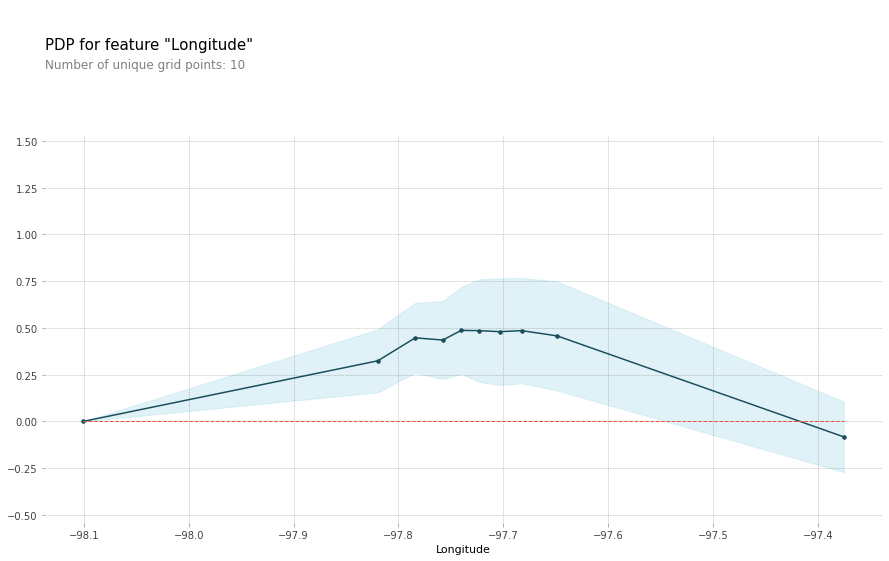

In [42]:
pdp_plot(isolated, feature_name=feature);

In [43]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Latitude'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

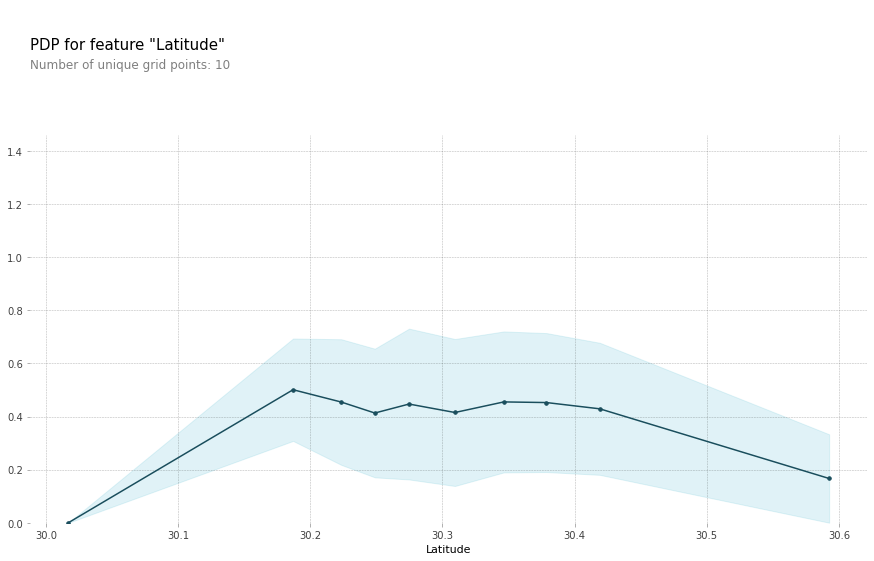

In [44]:
pdp_plot(isolated, feature_name=feature);

In [45]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Longitude', 'Latitude']

interaction = pdp_interact(
    model=model_xgb, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


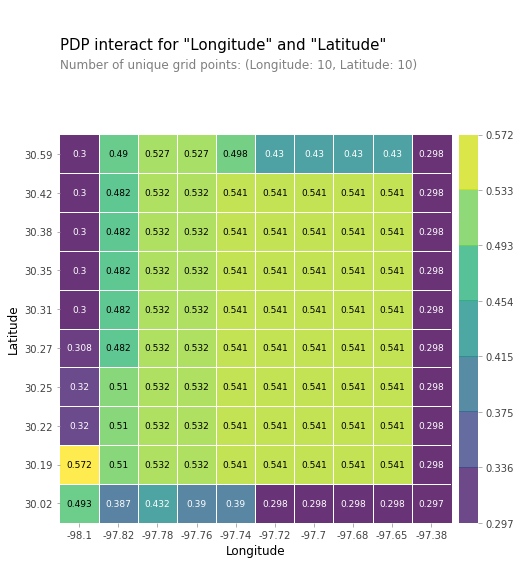

In [46]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

#Using the Model

In [47]:
y_val.value_counts()

1    4817
0    4791
Name: Urgent Accidents, dtype: int64

In [48]:
data = {'y_val': y_val,
        'y_pred': model_xgb.predict(X_val) }
results = pd.DataFrame(data)
results

,y_val,y_pred
Date time,,
12/16/2020,1,1
04/22/2021,1,1
08/03/2021,0,1
05/18/2021,0,1
02/03/2021,0,1
...,...,...
07/02/2021,1,1
05/15/2021,0,1
12/06/2020,1,1


In [49]:
results.value_counts()

y_val  y_pred
1      1         4413
0      1         2927
       0         1864
1      0          404
dtype: int64